In [167]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader

torch.manual_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128

train_dataset = MNIST(
  root="../../data", 
  download=True, 
  transform=transforms.ToTensor(),
  train=True
)
test_dataset = MNIST(
  root="../../data", 
  transform=transforms.ToTensor(),
  train=False
)

train_dataset, val_dataset = random_split(train_dataset, [55000, 5000])

train_loader = DataLoader(
  dataset=train_dataset,
  batch_size=batch_size,
  shuffle=True,
  num_workers=11,
)

val_loader = DataLoader(
  dataset=val_dataset,
  batch_size=batch_size,
  num_workers=11,
)

test_loader = DataLoader(
  dataset=test_dataset,
  batch_size=batch_size,
  num_workers=0,
)

example_img = test_dataset[0][0]
print(example_img.shape)


torch.Size([1, 28, 28])


In [168]:
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import torchmetrics
import lightning as L

class DownSample(L.LightningModule):
  def __init__(self, in_channels: int, out_channels: int):
    super().__init__()
    self.seq = nn.Sequential(OrderedDict([
      ('conv', nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)),
      ('relu', nn.ReLU()),
      ('maxpool', nn.MaxPool2d(2)),
    ]))


  def forward(self, x):
    return self.seq(x)


class UpSample(L.LightningModule):
  def __init__(self, in_channels: int, out_channels: int, act_fn: nn):
    super().__init__()
    self.seq = nn.Sequential(OrderedDict([
      ('conv', nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=2,
        stride=2
      )),
      ('upsample-act-fn', act_fn),
    ]))

  def forward(self, x):
    return self.seq(x)


class MnistAutoEncoder(L.LightningModule):
  def __init__(self):
    super().__init__()

    self.seq = nn.Sequential(OrderedDict([
      ('down1', DownSample(1, 32)),
      ('down2', DownSample(32, 64)),

      # bottleneck
      ('flatten', nn.Flatten()),
      ('bottleneck', nn.Linear(3136, 20)),
      ('relu', nn.ReLU()),
      ('lin2', nn.Linear(20, 3136)),
      ('unflatten', nn.Unflatten(1, (64, 7, 7))),

      ('up1', UpSample(64, 32, nn.ReLU())),
      ('up2', UpSample(32, 1, nn.Sigmoid())),
    ]))

  def forward(self, x):
    return self.seq(x)

  def _shared_step(self, batch):
    original_images, _unused_labels = batch
    reconstructions = self(original_images)

    loss = F.mse_loss(reconstructions, original_images)

    return loss, original_images, reconstructions

  def training_step(self, batch, batch_idx: int):
      loss, original_images, reconstructions = self._shared_step(batch)

      self.log('train_loss', loss, prog_bar=True)

      return loss # this is passed to the optimizer for training

  def validation_step(self, batch, batch_idx: int):
      loss, original_images, reconstructions = self._shared_step(batch)

      self.log('val_loss', loss, prog_bar=True)

  def test_step(self, batch, batch_idx: int):
      loss, original_images, reconstructions = self._shared_step(batch)

  def configure_optimizers(self):
      optimizer = torch.optim.AdamW(self.parameters(), lr=0.001)
      return optimizer



In [169]:
import lightning as L
from torchinfo import summary

model = MnistAutoEncoder().to(device)
summary(model, input_size=(batch_size, 1, 28, 28), depth=2)

trainer = L.Trainer(
  max_epochs=3,
  accelerator='gpu',
  devices='auto' # Use all available GPUs if applicable
)

trainer.fit(
  model,
  train_dataloaders=train_loader,
  val_dataloaders=val_loader
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | seq  | Sequential | 155 K  | train
--------------------------------------------
155 K     Trainable params
0         Non-trainable params
155 K     Total params
0.623     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [170]:
import torchvision
import matplotlib.pyplot as plt

if 'hooks' in locals():
  for hook in locals()['hooks']:
    hook.remove()

hooks: list[torch.utils.hooks.RemovableHandle] = []

layers = [
  'seq.down1', 'seq.down2', 'seq.up1', 'seq.up2'
]

for layer in layers:
  def inspect(module, input, output: torch.Tensor):
      output = output.transpose(0, 1)
      grid = torchvision.utils.make_grid(output)
      img = torchvision.transforms.ToPILImage()(grid)
      resize = int(200 / img.height)
      img.resize((resize * img.width, resize * img.height)).show() 
  hooks.append(model.get_submodule(layer).register_forward_hook(inspect))

@model.get_submodule('seq.bottleneck').register_forward_hook
def inspect_bottleneck(module, input, output: torch.Tensor):
  plt.imshow(output.detach().numpy(), cmap='gray')
  plt.show()
hooks.append(inspect_bottleneck)



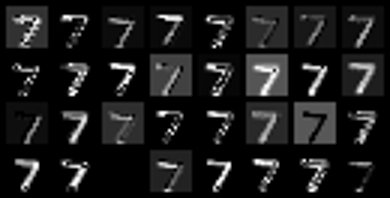

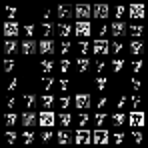

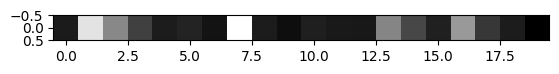

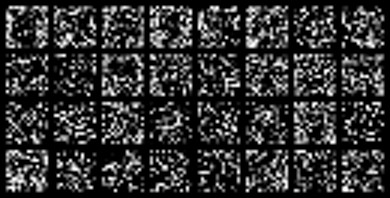

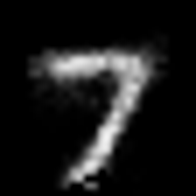

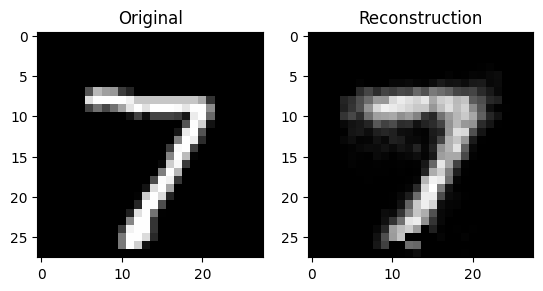

In [171]:

model.eval()

example_img = test_dataset[0][0]

reconstruction = model(example_img.view(1, 1, 28, 28))

from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.sca(ax1)
plt.title('Original')
plt.imshow(example_img.view(28, 28), cmap='gray')

plt.sca(ax2)
plt.title('Reconstruction')
plt.imshow(reconstruction.view(28, 28).detach().numpy(), cmap='gray')

for hook in hooks:
  hook.remove()


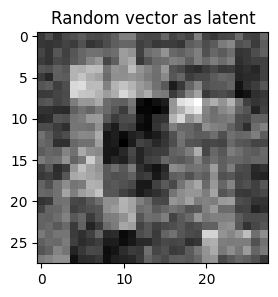

In [182]:
model.eval()

y = torch.rand(20).to(device).view(1, 20)
start = False

for name, module in model.get_submodule('seq').named_children():
  if name == 'lin2':
    start = True
  if start:
    y = module.to(device)(y)

plt.figure(figsize=(3, 3))
plt.title('Random vector as latent')
plt.imshow(y.detach().cpu().view(28, 28).detach().numpy(), cmap='gray')
